In [1]:

def no_recep_print_frame(oracleagent, loc):
    inst_color_count, inst_color_to_object_id = oracleagent.get_instance_seg()
    #recep_object_id = recep['object_id']

    # for each unique seg add to object dictionary if it's more visible than before
    visible_objects = []
    visible_objects_id = [] 
    visible_recep = [] 
    visible_recep_id = [] 
    
    #want it to be visible 

    c = inst_color_count
    new_inst_color_count = Counter({k: c for k, c in c.items() if c >= 10})
    
    for color, num_pixels in new_inst_color_count.most_common():
        if color in inst_color_to_object_id:
            
            
            object_id = inst_color_to_object_id[color]
            object_type = object_id.split("|")[0]
            object_metadata = oracleagent.get_obj_id_from_metadata(object_id)
            is_obj_in_recep = (object_metadata and object_metadata['parentReceptacles'] and len(object_metadata['parentReceptacles']) > 0) # and recep_object_id in object_metadata['parentReceptacles'])
            if object_id in oracleagent.receptacles.keys():
                
                visible_recep_id.append(object_id)
                visible_recep.append(oracleagent.receptacles[object_id]['num_id'])
            
            
            if object_type in oracleagent.OBJECTS and object_metadata and (not oracleagent.use_gt_relations or is_obj_in_recep):
                if object_id not in oracleagent.objects:
                    oracleagent.objects[object_id] = {
                        'object_id': object_id,
                        'object_type': object_type,
                        #'parent': recep['object_id'],
                        'loc': loc,
                        'num_pixels': num_pixels,
                        'num_id': "%s %d" % (object_type.lower() if "Sliced" not in object_id else "sliced-%s" % object_type.lower(),
                                             oracleagent.get_next_num_id(object_type, oracleagent.objects))
                    }
                elif object_id in oracleagent.objects and num_pixels > oracleagent.objects[object_id]['num_pixels']:
                    oracleagent.objects[object_id]['loc'] = loc
                    oracleagent.objects[object_id]['num_pixels'] = num_pixels

                if oracleagent.objects[object_id]['num_id'] not in oracleagent.inventory:
                    visible_objects.append(oracleagent.objects[object_id]['num_id'])
                    visible_objects_id.append(object_id)

    visible_objects_with_articles = ["a %s," % vo for vo in visible_objects]
    feedback = ""
    if len(visible_objects) > 0:
        feedback = "On the Receptacle, you see %s" % (oracleagent.fix_and_comma_in_the_end(' '.join(visible_objects_with_articles))) #recep['num_id']
    elif len(visible_objects) == 0: #not recep['closed'] and
        feedback = "On the Receptacle, you see nothing." #% (recep['num_id'])
    #pdb.set_trace()
    #print(visible_recep)
    return visible_objects, visible_objects_id, visible_recep, visible_recep_id, feedback

In [12]:
from torchvision import transforms

def results_success(model,desired_desc_ind, traj_len, rand = False):
    pick_success = 0
    nav_success = 0
    
    actions = [{'action': 'RotateRight'}, {'action': 'RotateLeft'}, {'action': 'MoveBack', 'moveMagnitude': 0.25}, {'action': 'MoveAhead', 'moveMagnitude': 0.25}, {'action': 'LookUp'},  {'action': 'LookDown'}]
    list_receps = ['Bed|+00.27|+00.00|+01.33', 'LaundryHamper|-01.44|+00.01|+01.77', 'Desk|-00.87|-00.01|-02.44', 'Shelf|-01.02|+01.35|-02.54', 'Drawer|-01.41|+00.73|-02.32', 'Drawer|-01.41|+00.48|-02.32', 'Drawer|-01.41|+00.20|-02.32', 'SideTable|+00.25|00.00|-02.38']
    img = [] # some array of images
    frames = [] # for storing the generated images

    traj = 0

    list_receps = None
    desired_desc_ind = desired_desc_ind
    #items in dataset
    obj_ds = [ 0,  2,  6,  7,  8, 12, 21, 22, 25, 29, 30, 33, 41, 43, 44, 47]
    obj_ds_len = len(obj_ds) + 1 
    print(unique_objs[local2globaldict[obj_ds[desired_desc_ind]]])

    traj = 0
    obs, info = env.reset()
    state_vec = []
    desc_vec = []
    action_vec = []
    pickable = []
    
    #
    scale_img =  transforms.Compose([transforms.Scale((64,64))])

    #initialize all of this here.
    game_state = env.envs[0].controller.navigator.game_state
    event = game_state.env.last_event
    pose = game_util.get_pose(event)
    oracleagent = env.envs[0].controller

    actions = [{'action': 'RotateRight'}, {'action': 'RotateLeft'}, {'action': 'MoveBack', 'moveMagnitude': 0.25}, {'action': 'MoveAhead', 'moveMagnitude': 0.25}, {'action': 'LookUp'},  {'action': 'LookDown'}, {'action': 'PickupObject'}]
    
    picked = False
    while traj < traj_len:
        traj += 1 

        desired_desc = torch.zeros(obj_ds_len) #17
        desired_desc[desired_desc_ind] = 1


        #current state
        image = env.get_frames()
        image = torch.from_numpy(image.squeeze(0))
        image = image

        all_objs = [x['objectId'] for x in oracleagent.env.last_event.metadata['objects']]
        pickable_objs = [x['objectId'] for x in oracleagent.env.last_event.metadata['objects'] if x['pickupable'] == True]
        visible_objs = [x['objectId'] for x in oracleagent.env.last_event.metadata['objects'] if x['visible'] == True]
        
        pick_objs = {}
        for x in oracleagent.env.last_event.metadata['objects']:
            if x['pickupable'] == True and x['visible'] == True:
                pick_objs[x['objectId']] = x['distance']
        pick_objs = sorted(pick_objs.items(), key=lambda x: x[1])

    

        if rand == False:
            state = image.expand(len(actions), -1,-1,-1)
            state = scale_img(state.permute(0,3,1,2))
            action = torch.Tensor(list(range(len(actions))))
            action = action.unsqueeze(1)
            action = torch.eye(len(actions))
            desired_desc = desired_desc.expand(len(actions),-1)

            with torch.no_grad():
                output = model(state, desired_desc, action)
                
            

            #p = output[:,1].numpy()
#             T=1
#             temp_output = torch.exp(output[:,1])
#             p = temp_output.numpy()
#             p /= p.sum()
#             action_ind = np.random.choice(len(actions), 1, replace=False, p=p).item()
            
        #TODO: argmax 
            action_ind = torch.argmax(output)
            print(output)
            print(action_ind)
            print(actions[action_ind]['action'])
            plt.imshow(image, interpolation='nearest')
            plt.show()
            pdb.set_trace()
    #     print(actions[action_ind])
    
        else:
            action_ind = random.randrange(len(actions))
#             print(actions[action_ind]['action'])


        #select pickup action
        print( actions[action_ind]['action'])
        if actions[action_ind]['action'] == 'PickupObject':

            #find pickable objects
            if len(pick_objs) == 0:
                #do nothing
                traj += 1 
                continue

            else:
#                 print(curr_pickable)
                picked_obj = pick_objs[0][0] #sample(curr_pickable, 1)[0]

                action = {'action': "PickupObject",'objectId': picked_obj, 'forceAction': True}
                try:
                    game_state.step(action)
                except Exception:
                    continue 


                image = env.get_frames()
                image = torch.from_numpy(image.squeeze(0))
                plt.imshow(image, interpolation='nearest')
                desired_obj = unique_objs[local2globaldict[obj_ds[desired_desc_ind]]]
                if picked_obj.split("|")[0] == desired_obj:
                    print("success")
                    pick_success = 1
                
                if desired_obj in [x[0].split("|")[0] for x in pick_objs]:
#                     print("navigation success")
                    nav_success = 1

#                 image = env.get_frames()
#                 image = torch.from_numpy(image.squeeze(0))


                break


        else: 
            game_state.step(actions[action_ind])

        
    
    return traj, pick_success, nav_success


def sim(model, desired_desc_ind, simulations = 1, rand = False):
    #non random
    pick_list = []
    nav_list = []
    traj_list = []
    for traj_len in [20]:
        pick_success_count = 0
        nav_success_count = 0 
#         print('traj_len {}'.format(traj_len))
        for i in range(simulations):
#             print("simulation no: {}".format(i))
            traj, success, nav_success = results_success(model, desired_desc_ind, traj_len, rand = rand)
#             print("simulation is successful: {}".format(success))
#             print("navigation is successful: {}".format(nav_success))
            pick_list.append(success)
            nav_list.append(nav_success)
            traj_list.append(traj)
            
    return {'pick_'+ str(desired_desc_ind): pick_list, 'nav_'+ str(desired_desc_ind): nav_list, 'traj_'+ str(desired_desc_ind): traj_list}

def dict_mean(dict_list):
    mean_dict = {}
    for key, value in dict_list.items():
        if 'pick' in key:
            mean_dict[key] = sum(value) / len(value)
    return mean_dict

In [9]:
import os 
import time 
import numpy as np
import alfworld.agents.environment as environment
import alfworld.agents.modules.generic as generic
import pdb
from collections import Counter
from random import sample
from tqdm import tqdm
import alfworld.gen.constants as constants
import torch
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import PIL.Image
import PIL.ImageDraw
import tqdm
import json
from constants import *
from alfworld.gen.utils import game_util
import random
import pandas as pd
from IPython.display import display, HTML


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from model import *
from IPython.display import HTML


trajs = ['pick_and_place_simple-Watch-None-CoffeeTable-201',
 'pick_and_place_simple-CellPhone-None-SideTable-317',
 'pick_and_place_simple-Tomato-None-Microwave-13',
 'pick_and_place_simple-Statue-None-CoffeeTable-222',
 'pick_and_place_simple-Newspaper-None-Ottoman-203',
 'pick_and_place_simple-SoapBottle-None-GarbageCan-421',
 'pick_and_place_simple-Candle-None-Toilet-405',
 'pick_and_place_simple-AlarmClock-None-Desk-307/trial_T20190907_072303_146844',
 'pick_and_place_simple-Knife-None-SideTable-3',
 'pick_and_place_simple-Plunger-None-Cabinet-403']

# load config
traj_name = trajs[7]

config = {'dataset': {'data_path': '$ALFWORLD_DATA/json_2.1.1/train/{}'.format(traj_name), 'eval_id_data_path': '$ALFWORLD_DATA/json_2.1.1/valid_seen', 'eval_ood_data_path': '$ALFWORLD_DATA/json_2.1.1/valid_unseen', 'num_train_games': 1, 'num_eval_games': -1}, 'logic': {'domain': '$ALFWORLD_DATA/logic/alfred.pddl', 'grammar': '$ALFWORLD_DATA/logic/alfred.twl2'}, 'env': {'type': 'AlfredThorEnv', 'regen_game_files': False, 'domain_randomization': False, 'task_types': [1, 2, 3, 4, 5, 6], 'expert_timeout_steps': 150, 'expert_type': 'handcoded', 'goal_desc_human_anns_prob': 0.0, 'hybrid': {'start_eps': 100000, 'thor_prob': 0.5, 'eval_mode': 'tw'}, 'thor': {'screen_width': 300, 'screen_height': 300, 'smooth_nav': False, 'save_frames_to_disk': False, 'save_frames_path': './videos/'}}, 'controller': {'type': 'oracle_astar', 'debug': False, 'load_receps': True}, 'mask_rcnn': {'pretrained_model_path': '$ALFWORLD_DATA/detectors/mrcnn.pth'}, 'general': {'random_seed': 42, 'use_cuda': True, 'visdom': False, 'task': 'alfred', 'training_method': 'dagger', 'save_path': './training/', 'observation_pool_capacity': 3, 'hide_init_receptacles': False, 'training': {'batch_size': 10, 'max_episode': 50000, 'smoothing_eps': 0.1, 'optimizer': {'learning_rate': 0.001, 'clip_grad_norm': 5}}, 'evaluate': {'run_eval': True, 'batch_size': 10, 'env': {'type': 'AlfredTWEnv'}}, 'checkpoint': {'report_frequency': 1000, 'experiment_tag': 'test', 'load_pretrained': False, 'load_from_tag': 'not loading anything'}, 'model': {'encoder_layers': 1, 'decoder_layers': 1, 'encoder_conv_num': 5, 'block_hidden_dim': 64, 'n_heads': 1, 'dropout': 0.1, 'block_dropout': 0.1, 'recurrent': True}}, 'rl': {'action_space': 'admissible', 'max_target_length': 20, 'beam_width': 10, 'generate_top_k': 3, 'training': {'max_nb_steps_per_episode': 50, 'learn_start_from_this_episode': 0, 'target_net_update_frequency': 500}, 'replay': {'accumulate_reward_from_final': True, 'count_reward_lambda': 0.0, 'novel_object_reward_lambda': 0.0, 'discount_gamma_game_reward': 0.9, 'discount_gamma_count_reward': 0.5, 'discount_gamma_novel_object_reward': 0.5, 'replay_memory_capacity': 500000, 'replay_memory_priority_fraction': 0.5, 'update_per_k_game_steps': 5, 'replay_batch_size': 64, 'multi_step': 3, 'replay_sample_history_length': 4, 'replay_sample_update_from': 2}, 'epsilon_greedy': {'noisy_net': False, 'epsilon_anneal_episodes': 1000, 'epsilon_anneal_from': 0.3, 'epsilon_anneal_to': 0.1}}, 'dagger': {'action_space': 'generation', 'max_target_length': 20, 'beam_width': 10, 'generate_top_k': 5, 'unstick_by_beam_search': False, 'training': {'max_nb_steps_per_episode': 50}, 'fraction_assist': {'fraction_assist_anneal_episodes': 50000, 'fraction_assist_anneal_from': 1.0, 'fraction_assist_anneal_to': 0.01}, 'fraction_random': {'fraction_random_anneal_episodes': 0, 'fraction_random_anneal_from': 0.0, 'fraction_random_anneal_to': 0.0}, 'replay': {'replay_memory_capacity': 500000, 'update_per_k_game_steps': 5, 'replay_batch_size': 64, 'replay_sample_history_length': 4, 'replay_sample_update_from': 2}}, 'vision_dagger': {'model_type': 'resnet', 'resnet_fc_dim': 64, 'maskrcnn_top_k_boxes': 10, 'use_exploration_frame_feats': False, 'sequence_aggregation_method': 'average'}}
env_type = 'AlfredThorEnv' # config['env']['type'] # 'AlfredTWEnv' or 'AlfredThorEnv' or 'AlfredHybrid'



# setup environment
env = getattr(environment, env_type)(config, train_eval='train')
env = env.init_env(batch_size=1)

# interact
obs, info = env.reset()


Initialize AlfredThorEnv...
Overall we have 1 games...
Training with 1 games
Overall we have 1 games...
Training with 1 games
Viewer: http://127.0.0.1:38026/viewer
ThorEnv started.
Resetting ThorEnv
Task: put a alarmclock in desk


In [10]:
import pandas as pd


res_path = '/home/dongwonl/local/alf_env/alfworld/model_weights/results_largerds_10000_argmax_lcrl_5.csv'
    


if os.path.exists(res_path) == False:
    Done = []
    col = ['model','epoch']
    objs = [ 0,  2,  6,  7,  8, 12, 21, 22, 25, 29, 30, 33, 41, 43, 44, 47]
    for obj in range(len(objs)):
        obj = str(obj)
        col.append("pick_{}".format(obj))
        
    df = pd.DataFrame(columns=col)

else: 
    df = pd.read_csv(res_path)
    Done = df.model.to_list()
    
weights_dir = "/home/dongwonl/local/alf_env/alfworld/model_weights/pick_LCRL_Suraj_2/pick_and_place_simple-AlarmClock-None-Desk-307"
NotDone = os.listdir(weights_dir)
NotDone = [x for x in NotDone if '.npy' not in x]
NotDone




['QFunc_epoch[4000]_999_pick.pth',
 'QFunc_epoch[1200]_999_pick.pth',
 'QFunc_epoch[2200]_999_pick.pth',
 'QFunc_epoch[3200]_999_pick.pth',
 'QFunc_epoch[1000]_999_pick.pth',
 'QFunc_epoch[4200]_999_pick.pth',
 'QFunc_epoch[3000]_999_pick.pth',
 'QFunc_epoch[2000]_999_pick.pth',
 'QFunc_epoch[200]_999_pick.pth',
 'QFunc_epoch[2800]_999_pick.pth',
 'QFunc_epoch[3600]_999_pick.pth',
 'QFunc_epoch[400]_999_pick.pth',
 'QFunc_epoch[2600]_999_pick.pth',
 'QFunc_epoch[3800]_999_pick.pth',
 'QFunc_epoch[1600]_999_pick.pth',
 'QFunc_epoch[1800]_999_pick.pth',
 'QFunc_epoch[4400]_999_pick.pth',
 'QFunc_epoch[2400]_999_pick.pth',
 'QFunc_epoch[600]_999_pick.pth',
 'QFunc_epoch[3400]_999_pick.pth',
 'QFunc_epoch[800]_999_pick.pth',
 'QFunc_epoch[0]_999_pick.pth',
 'QFunc_epoch[1400]_999_pick.pth']

Pen
Resetting ThorEnv
Task: put some alarmclock on desk
tensor([[0.0323],
        [0.0323],
        [0.0324],
        [0.0323],
        [0.0323],
        [0.0323],
        [0.9897]])
tensor(6)
PickupObject


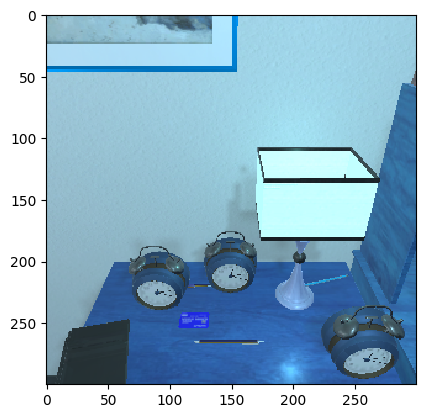

> <ipython-input-12-68155bc25a44>(100)results_success()
     98 
     99         #select pickup action
--> 100         print( actions[action_ind]['action'])
    101         if actions[action_ind]['action'] == 'PickupObject':
    102 

ipdb> pick_objs
[('Pen|+00.25|+00.82|-02.30', 0.5618957), ('AlarmClock|-00.06|+00.81|-02.24', 0.586104155), ('CreditCard|+00.36|+00.81|-02.37', 0.63746196), ('AlarmClock|+00.46|+00.81|-02.44', 0.7276491), ('AlarmClock|+00.25|+00.81|-02.51', 0.7633934), ('Pen|+00.36|+00.82|-02.51', 0.773425758), ('Pencil|-00.06|+00.81|-02.51', 0.842899859)]
ipdb> q


BdbQuit: 

In [13]:


while True:
    NotDone = os.listdir(weights_dir)
    NotDone = [x for x in NotDone if '.npy' not in x]
    NeedsEval = set(NotDone) - set(Done)
    if len(NeedsEval) > 0:
        for curr_file in NeedsEval:
            start_time = time.time()
            full_res_dict = {}
            full_res_dict['model'] = curr_file
            full_res_dict['epoch'] = curr_file[curr_file.find("[")+1 : curr_file.find("]")]
            curr_path = os.path.join(weights_dir, curr_file )
            model_state = torch.load(curr_path, map_location=torch.device('cpu'))
            objs = [ 0,  2,  6,  7,  8, 12, 21, 22, 25, 29, 30, 33, 41, 43, 44, 47]
            desc_num_classes = len(objs) + 1 #17
            action_num_classes = 7
            model = QFunc(desc_num_classes, action_num_classes)
            model.load_state_dict(model_state)
            model.eval()

            for obj_ind in range(14,len(objs)):
                results = sim(model, obj_ind, simulations = 1, rand = False)
                results_dict = dict_mean(results)
                full_res_dict.update(results_dict)
                
            df2 = full_res_dict
            df = df.append(df2, ignore_index = True)
            
            
            df['epoch']=df.epoch.astype('int64')
            df = df.sort_values(by=['epoch'])
            display(df)
            
            df.to_csv(res_path)
            
            #delete file after eval 
            Done.append(curr_file)
            print("--- %s seconds ---" % (time.time() - start_time))
        
#     if len(NeedsEval) == 0:
#         pdb.set_trace()
        
    
    

In [ ]:
df2

In [ ]:
df
df = df.append(df2, ignore_index = True)

In [ ]:
df2

In [ ]:
import pandas as pd

res_path = '/home/dongwonl/local/alf_env/alfworld/model_weights/results.csv'
full_res_dict = pd.read_csv(res_path).sort_values(by=['epoch'])
full_res_dict

In [ ]:
import pandas as pd

res_path = '/home/dongwonl/local/alf_env/alfworld/model_weights/results_largerds.csv'
full_res_dict = pd.read_csv(res_path).sort_values(by=['epoch'])
full_res_dict

In [ ]:
curr_path = "/home/dongwonl/local/alf_env/alfworld/model_weights/pick5_check/ClassifierCRActionResnetDropout_FuseAction_epoch[4600]_47_pick.pth"

In [ ]:

model_state = torch.load(curr_path, map_location=torch.device('cpu'))
desc_num_classes = 4 #17
action_num_classes = 7


In [ ]:
model = ClassifierCRActionResnetDropout_FuseAction(desc_num_classes, action_num_classes)
model.load_state_dict(model_state)
model.eval()